In [146]:
import cv2
import numpy as np
import os
import sys
import torch

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import pdb

# Paths

In [2]:
vid_path = '/data/vision/torralba/summarization/shape-prior-3d/misc/data'

# Functions

In [60]:
def load_video_data(filename):
    '''
    Load the pre-computed pose of the video clip.
    '''
    metadata = {
        #'url': None,
    }
    with open(filename, 'r') as fd:
        for idx, l in enumerate(fd.readlines()):
            if idx == 0:
                # url to the corresponding youtube video
                pass
                #metadata['url'] = l.strip()
            else:
                # load camera intrinsics and extrinsics
                info = [float(i) for i in l.strip().split()]
                metadata[info[0]] = {}
                metadata[info[0]]['K'] = np.array([[info[1], 0, info[3]], [0, info[2], info[4]], [0, 0, 1]])
                metadata[info[0]]['P'] = np.array(info[7:]).reshape(3, 4)     

    return metadata    

In [99]:
def map_frame_with_pose(vid_name, metadata, threshold=2*1e4):
    cap = cv2.VideoCapture(vid_name)
    pose_stamp = np.array(list(metadata.keys()))
    max_pose_stamp = pose_stamp.max()
    
    frame_cnt = 0
    
    pose2time = {}        
    while True:
        try:
            ret, frame = cap.read()
        except:
            print('Cannot read the frame!')
        timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)
        timestamp *= 1000 # convert to micro-seconds
        
        cur_diff = np.abs(pose_stamp - timestamp)
        if cur_diff.min() < threshold:
            #pdb.set_trace()
            match_idx = pose_stamp[cur_diff.argmin()]
            pose2time[match_idx] = {
                'timestamp': timestamp,
                'frame_idx': frame_cnt
            }
            print(f'Match frame {frame_cnt}! Time difference {(timestamp - match_idx)}')
            
                    
        if (timestamp - max_pose_stamp) > 5 * 1e6:
            break

        frame_cnt += 1            
            
    cap.release()    

    return pose2time
    

In [104]:
def get_camera_wireframe(scale: float = 0.3):
    """
    Returns a wireframe of a 3D line-plot of a camera symbol.
    """
    a = 0.5 * torch.tensor([-2, 1.5, 4])
    b = 0.5 * torch.tensor([2, 1.5, 4])
    c = 0.5 * torch.tensor([-2, -1.5, 4])
    d = 0.5 * torch.tensor([2, -1.5, 4])
    C = torch.zeros(3)
    F = torch.tensor([0, 0, 3])
    camera_points = [a, b, d, c, a, C, b, d, C, c, C, F]
    lines = torch.stack([x.float() for x in camera_points]) * scale
    return lines


def plot_cameras(ax, cameras, color: str = "blue"):
    """
    Plots a set of `cameras` objects into the maplotlib axis `ax` with
    color `color`.
    """
    #cam_wires_canonical = get_camera_wireframe().cuda()[None]
    cam_wires_canonical = get_camera_wireframe(20)
    cam_wires_canonical = torch.cat((cam_wires_canonical, torch.ones(12, 1)), dim=1)
    
    #import pdb; pdb.set_trace()
    cam_wires_trans = cam_wires_canonical.unsqueeze(0) @ torch.inverse(cameras).transpose(1, 2)
    cam_wires_trans = cam_wires_trans[:, :, :3]
    #cam_trans = cameras.get_world_to_view_transform().inverse()
    #cam_wires_trans = cam_trans.transform_points(cam_wires_canonical)
    #pdb.set_trace()
        
    plot_handles = []
    for wire in cam_wires_trans:
        # the Z and Y axes are flipped intentionally here!
        x_, z_, y_ = wire.detach().cpu().numpy().T.astype(float)
        #import pdb; pdb.set_trace()
        (h,) = ax.plot(x_, y_, z_, color=color, linewidth=1)
        plot_handles.append(h)
    return plot_handles


def plot_camera_scene(cameras, cameras_gt, status: str):
    """
    Plots a set of predicted cameras `cameras` and their corresponding
    ground truth locations `cameras_gt`. The plot is named with
    a string passed inside the `status` argument.
    """
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.clear()
    ax.set_title(status)
    handle_cam = plot_cameras(ax, cameras, color="#FF7D1E")
    #handle_cam_gt = plot_cameras(ax, cameras_gt, color="#812CE5")
    plot_radius = 5
#     ax.set_xlim3d([-0.5, 0.5])
#     ax.set_ylim3d([-5, -4])
#     ax.set_zlim3d([-0.5, 0.5])    
#     ax.set_xlim3d([-plot_radius, plot_radius])
#     ax.set_ylim3d([-plot_radius, plot_radius])
#     ax.set_zlim3d([-plot_radius, plot_radius])
#     ax.set_xlim3d([209, 211])
#     ax.set_ylim3d([-10, -11])
#     ax.set_zlim3d([314, 310])
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_zlabel("y")
    #ax.invert_yaxis()
    #ax.set_aspect('auto')
    labels_handles = {
        "Estimated cameras": handle_cam[0],
        #"GT cameras": handle_cam_gt[0],
    }
    ax.legend(
        labels_handles.values(),
        labels_handles.keys(),
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
    )
    plt.show()
    return fig

In [61]:
metadata = load_video_data('/data/vision/torralba/summarization/shape-prior-3d/mannequin/MannequinChallenge/train/0a312f741fdf5d89.txt')

In [103]:
pose2time = map_frame_with_pose(os.path.join(vid_path, 'maple_school.mp4'), metadata)

Match frame 9529! Time difference -0.3333333134651184
Match frame 9531! Time difference 0.0
Match frame 9533! Time difference 0.3333333730697632
Match frame 9535! Time difference -0.3333333730697632
Match frame 9537! Time difference 0.0
Match frame 9539! Time difference 0.3333333730697632
Match frame 9541! Time difference -0.3333333134651184
Match frame 9543! Time difference 5.960464477539063e-08
Match frame 9545! Time difference 0.3333333730697632
Match frame 9547! Time difference -0.3333333134651184
Match frame 9549! Time difference 5.960464477539063e-08
Match frame 9551! Time difference 0.3333333730697632
Match frame 9553! Time difference -0.33333325386047363
Match frame 9555! Time difference 0.0
Match frame 9557! Time difference 0.3333333134651184
Match frame 9559! Time difference -0.3333333134651184
Match frame 9561! Time difference 0.0
Match frame 9563! Time difference 0.3333333730697632
Match frame 9565! Time difference -0.3333333134651184
Match frame 9567! Time difference 0.0
M

In [82]:
pose2time[317950967.0]

{'timestamp': 317984333.3333333, 'frame_idx': 9530}

In [106]:
pose2time[318017700.0]

{'timestamp': 318017700.0, 'frame_idx': 9531}

# Visualize image and camera pose

In [143]:
cap = cv2.VideoCapture(os.path.join(vid_path, 'maple_school.mp4'))
frame_cnt = 0

frame_list = []
while True:
    ret, frame = cap.read()
    if frame_cnt in [9530, 9531, 9685]:
        frame_list.append(frame)
    
    if frame_cnt > 9685:
        break
    frame_cnt += 1

In [138]:
N = 10
bcc = torch.eye(4).unsqueeze(0).repeat(N, 1, 1)
for idx, i in enumerate(sorted(list(metadata.keys()))[::50]):
    if idx >= 10:
        break
    else:
        bcc[idx, :3] = torch.from_numpy(metadata[i]['P']).float()


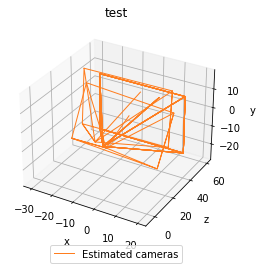

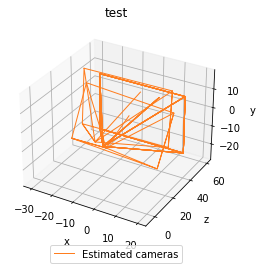

In [139]:
plot_camera_scene(bcc, bcc, 'test')

In [120]:
metadata[317950967.0]['P'], metadata[318017700.0]['P']

(array([[ 0.99528938, -0.03619116,  0.08994055,  1.97403009],
        [ 0.03459859,  0.9992168 ,  0.01920385, -3.91297031],
        [-0.09056512, -0.01600157,  0.99576199,  4.82483016]]),
 array([[ 0.99406862, -0.04118028,  0.10065698,  1.94805012],
        [ 0.03910701,  0.99898201,  0.02248542, -3.83835999],
        [-0.10148046, -0.01841566,  0.99466705,  4.71260978]]))

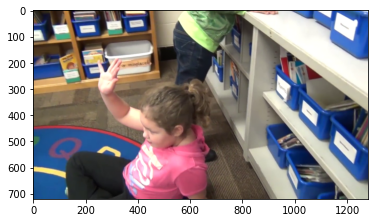

In [111]:
plt.imshow(frame_list[0][:, :, ::-1])

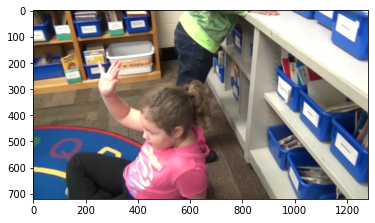

In [112]:
plt.imshow(frame_list[1][:, :, ::-1])

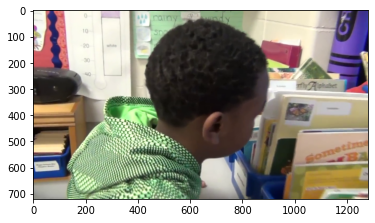

In [144]:
plt.imshow(frame_list[2][:, :, ::-1])

In [ ]:
# only visualize hd cameras for now
bcc = None
for k, cam in cameras.items():
    if k[0] != 0:
        continue       
        
    # Draw selected camera subset in blue
    cc = torch.eye(4).unsqueeze(0)
    cc[0, :3, :3] = torch.from_numpy(cam['R']).float()
    cc[0, :3, 3] = torch.from_numpy(cam['t']).float().squeeze()
    
    if bcc is None:
        bcc = cc
    else:
        bcc = torch.cat((bcc, cc), dim=0)
    #plot_camera_scene(cc, cc, 'test')
    #print((-cam['R'].transpose()*cam['t']))
    #import pdb; pdb.set_trace()
    #print(k)

plot_camera_scene(bcc, bcc, 'test')

# Load Video

In [30]:
cap = cv2.VideoCapture(os.path.join(vid_path, 'maple_school.mp4'))
frame_cnt = 0
while True:
    ret, frame = cap.read()
    timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)
    timestamp *= 1000
    print(f'frame {frame_cnt}: {timestamp}')
    frame_cnt += 1
    if np.abs(timestamp - 17950967) < 1000000 or frame_cnt > 1000:
        break
cap.release()

frame 0: 0.0
frame 1: 33366.666666666664
frame 2: 66733.33333333333
frame 3: 100100.00000000001
frame 4: 133466.66666666666
frame 5: 166833.33333333334
frame 6: 200200.00000000003
frame 7: 233566.66666666666
frame 8: 266933.3333333333
frame 9: 300300.0
frame 10: 333666.6666666667
frame 11: 367033.3333333334
frame 12: 400400.00000000006
frame 13: 433766.6666666667
frame 14: 467133.3333333333
frame 15: 500500.00000000006
frame 16: 533866.6666666666
frame 17: 567233.3333333334
frame 18: 600600.0
frame 19: 633966.6666666667
frame 20: 667333.3333333334
frame 21: 700700.0
frame 22: 734066.6666666667
frame 23: 767433.3333333334
frame 24: 800800.0000000001
frame 25: 834166.6666666667
frame 26: 867533.3333333334
frame 27: 900900.0000000001
frame 28: 934266.6666666666
frame 29: 967633.3333333334
frame 30: 1001000.0000000001
frame 31: 1034366.6666666665
frame 32: 1067733.3333333333
frame 33: 1101100.0
frame 34: 1134466.6666666667
frame 35: 1167833.3333333333
frame 36: 1201200.0
frame 37: 1234566.

frame 463: 15448766.666666668
frame 464: 15482133.333333334
frame 465: 15515500.000000002
frame 466: 15548866.666666666
frame 467: 15582233.333333336
frame 468: 15615600.0
frame 469: 15648966.66666667
frame 470: 15682333.333333334
frame 471: 15715700.0
frame 472: 15749066.666666668
frame 473: 15782433.333333334
frame 474: 15815800.000000002
frame 475: 15849166.666666668
frame 476: 15882533.333333334
frame 477: 15915900.000000002
frame 478: 15949266.666666668
frame 479: 15982633.333333336
frame 480: 16016000.000000002
frame 481: 16049366.666666666
frame 482: 16082733.333333334
frame 483: 16116099.999999998
frame 484: 16149466.66666667
frame 485: 16182833.333333334
frame 486: 16216200.0
frame 487: 16249566.666666666
frame 488: 16282933.333333332
frame 489: 16316300.000000002
frame 490: 16349666.666666668
frame 491: 16383033.333333332
frame 492: 16416399.999999998
frame 493: 16449766.66666667
frame 494: 16483133.333333336
frame 495: 16516500.0
frame 496: 16549866.666666664
frame 497: 1658

In [34]:
np.abs(timestamp - 17950967) / 1000000

0.9673336666666642

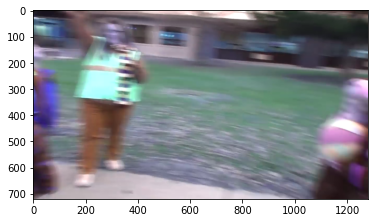

In [35]:
plt.imshow(frame)

In [28]:
33666966 - 17950967

15715999

In [20]:
for i in range(1000):
    ret, frame = cap.read()
    #plt.imshow(frame)

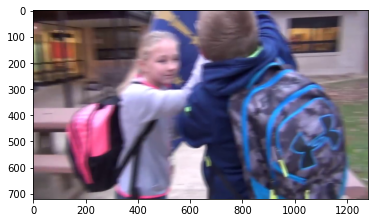

In [22]:
plt.imshow(frame[:, :, ::-1])

In [153]:
a = os.system("ls /data/vision/torralba/summarization/shape-prior-3d/mannequin/MannequinChallenge/train")

0